In [2]:
%matplotlib inline

import numpy as np
import scipy as scp
import re
import os
import sys
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import Align
import matplotlib.pyplot as plt
import itertools
from joblib import load

# adding project folder to lib search path
project = "/".join((os.path.split(os.getcwd())[0], os.path.split(os.getcwd())[1], 'scripts'))
if project not in sys.path:
    sys.path.append(project)
    
from loader import *
from work_with_files import *
from patients_and_translation import *
import phylo_tree
import classificator_k_mer
from data_prep_k_mer import *
from calculating_metrics import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
haplo_seq_dict, days = read_fasta_haplo('data/fasta/hivevo_p1_V3.fasta')
seq_dict, seq_name_days_dict = preparing_data(haplo_seq_dict, days)
prot_dict = translating_seqs(seq_dict)

### Hydro / n(SNP)

In [5]:
# calculating SNP's for every haplotype
# snp_dict = { day: [list of SNP's for every haplo ]}
snp_dict = {day:[] for day in days}
ref_seq = seq_dict['reference']
for day in seq_name_days_dict.keys():
    for seq_name in seq_name_days_dict[day]:
        snp_dict[day].append(calculating_snp(ref_seq, seq_dict[seq_name]))

In [6]:
# All this function are to make graphs

def hydro_snp(seq_name_days_dict, seq_dict):
    """ 
    Make X and Y for graph SNPs -> X, Hydro_metric -> Y
    Remind: here only one patient is analyzed
    Args:
        seq_name_days_dict: dict, {day: [list of name for every haplo for this day]}
        seq_dict: dict, {name: sequence}
    Returns:
        X: list, list of SNPs
        Y: list, list of metric_
        """
    
    # making dir for SNPs; {Num of SNPs: [metric for all seq with that num of SNPs]}
    snp_hydro_dict = {}
    
    # will analyze reference separetely from others
    ref_seq = seq_dict['reference']
    snp_hydro_dict[0] = [calculate_metric(ref_seq)]
    
    # for-loop for analyzing (counting metrics) for every haplo
    # taking one day
    for day in seq_name_days_dict.keys():
        # taking all seqs for this day
        for seq_name in seq_name_days_dict[day]:
            # calculating metric
            snp = calculating_snp(ref_seq, seq_dict[seq_name])
            
            # if for adding snp in dict, if it wasn't here
            if snp not in snp_hydro_dict:
                snp_hydro_dict[snp] = []
            # appending to list
            snp_hydro_dict[snp].append(calculate_metric(seq_dict[seq_name]))
    
    # creating lists to return
    X = []
    Y = []

    for snp in sorted(snp_hydro_dict.keys()):
        X.append(snp)
        Y.append(np.array(snp_hydro_dict[snp]).mean())
    
    return X, Y

def pat_snp(patients):
    """
    Taking needed patients and using all functions above on it
    Args:
        patients: list with all patients
    Return:
        pat_X: list, with all Xs, where X is like in hydro_snp func
        pat_Y: list, with all Ys, where X is like in hydro_snp func
        patients_used: list, o_O
    """
    pat_X, pat_Y = [], []
    
    patients_used = []
    
    for patient in patients:
        # We will not use patient#3 and patient#10 because their HIV wasn't cool at all
        # joke, additional info can be found here (https://elifesciences.org/articles/11282)
        if patient != 'p3' and patient != 'p10':
            # reading fasta for patient
            haplo_seq_dict, days = read_fasta_haplo('data/fasta/hivevo_{}_V3.fasta'.format(patient))
            
            # using all skills and mana on it
            seq_dict, seq_name_days_dict = preparing_data(haplo_seq_dict, days)
            prot_dict = translating_seqs(seq_dict)
            
            # creating X and Y
            X, Y = hydro_snp(seq_name_days_dict, seq_dict)
            
            # appending
            pat_X.append(X)
            pat_Y.append(Y)
            
            # o_O x2
            
            patients_used.append(patient)
    
    return pat_X, pat_Y, patients_used

pat_X, pat_Y, patients_used = pat_snp(patients)

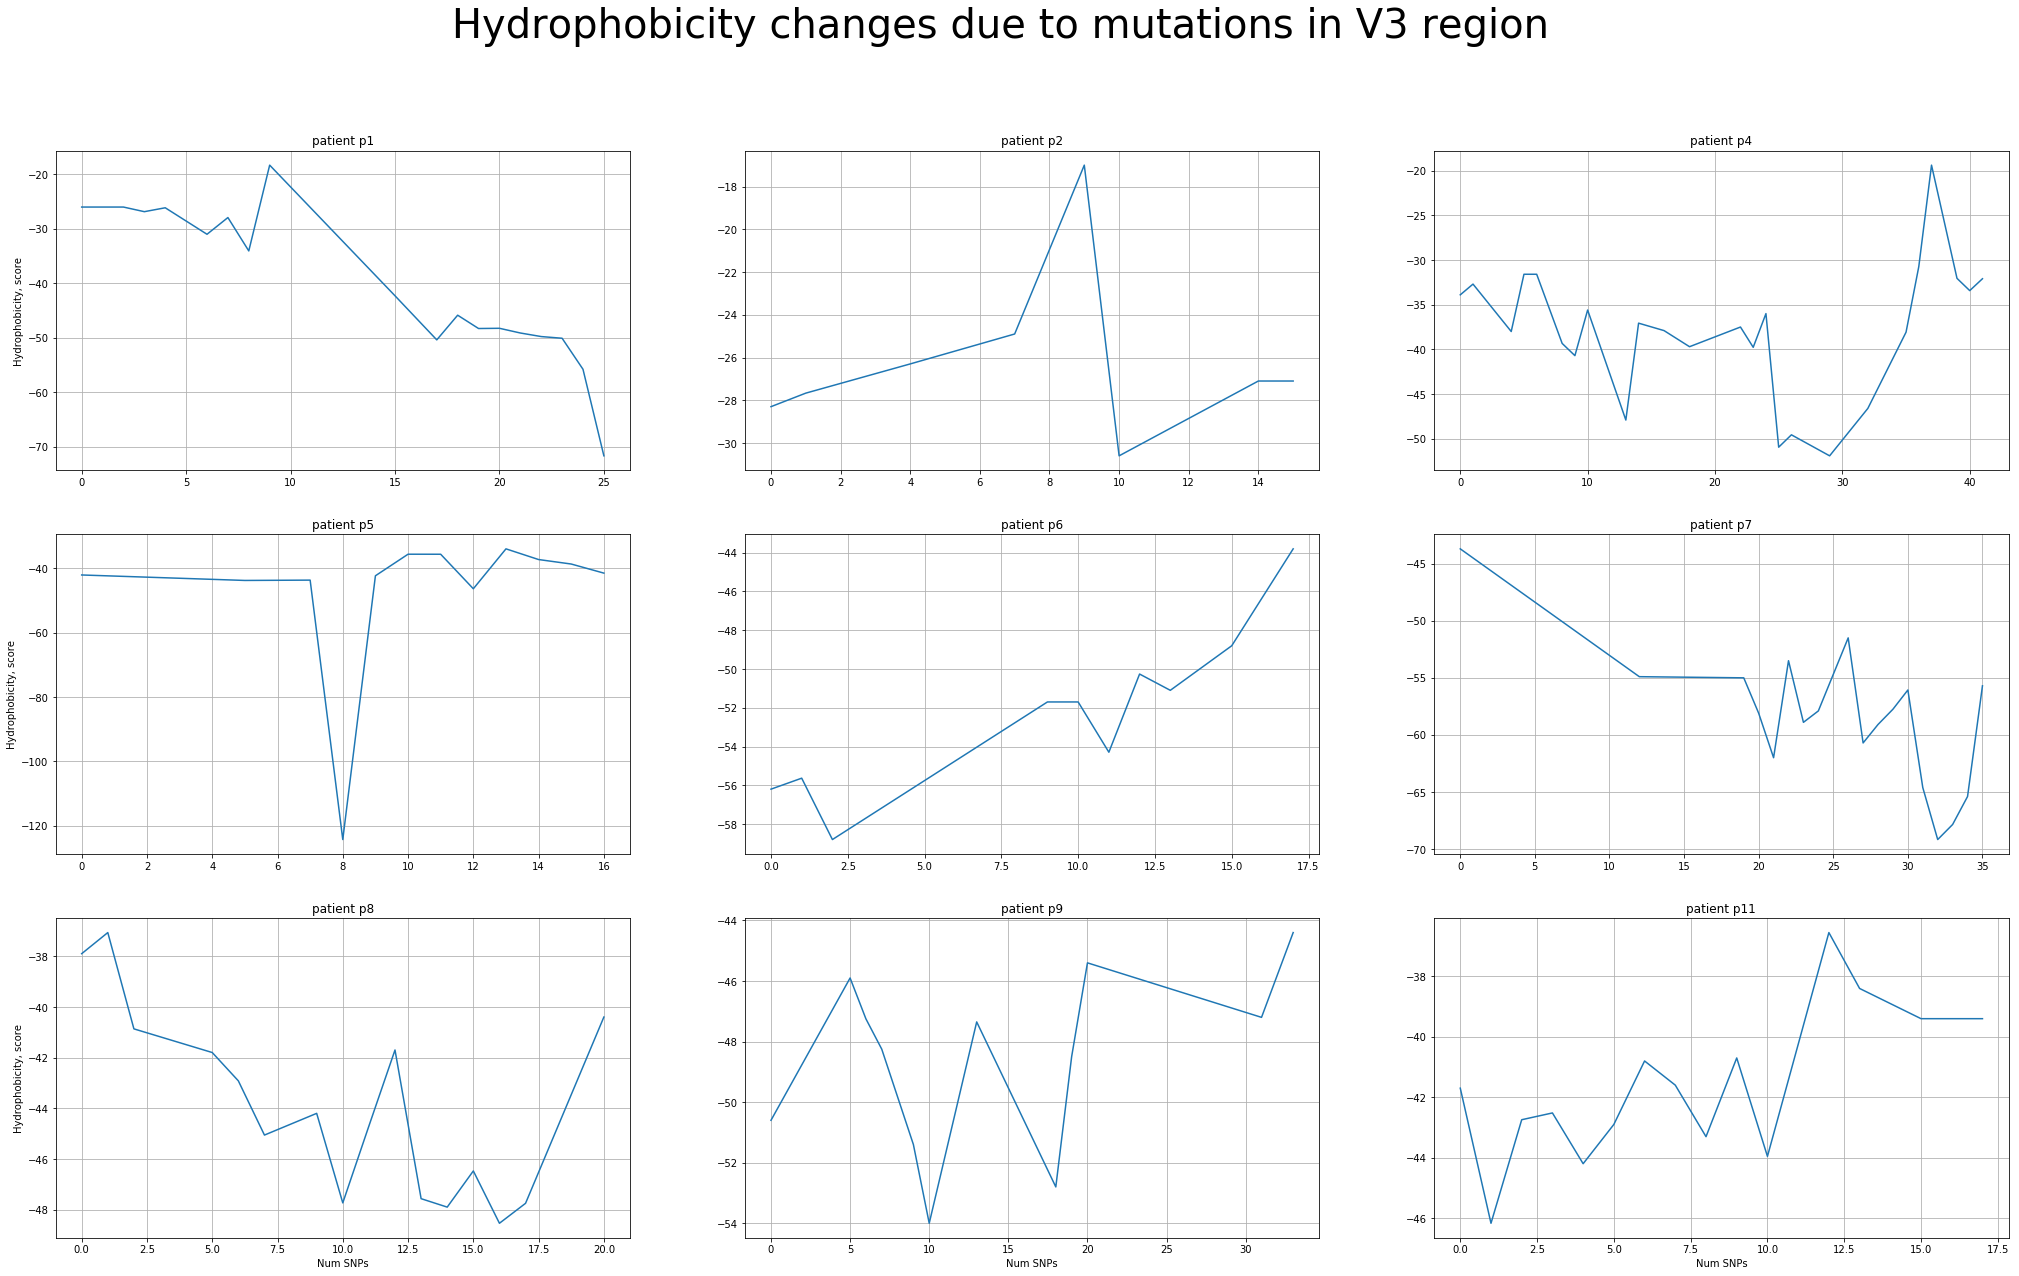

In [7]:
# Plotting

fig, axs = plt.subplots(3, 3, figsize = (35, 20), sharex = 'none', sharey = 'none')
#fig.figsize = (20, 16)
i = 0

for x in range(3):
    for y in range(3):
        axs[x, y].plot(pat_X[i], pat_Y[i])
        axs[x, y].set_title('patient {}'.format(patients_used[i]))
        axs[x, y].grid()
        i += 1

# Sadly it should be here because of my newbie skills in pyplot
axs[0, 0].set(ylabel='Hydrophobicity, score')
axs[1, 0].set(ylabel='Hydrophobicity, score')
axs[2, 0].set(ylabel='Hydrophobicity, score')

axs[2, 0].set(xlabel='Num SNPs')
axs[2, 1].set(xlabel='Num SNPs')
axs[2, 2].set(xlabel='Num SNPs')

fig.suptitle('Hydrophobicity changes due to mutations in V3 region', fontsize = 40)
plt.savefig('results/hydrophobicity_plot/hydrophobicity_snp_plot.png')

### Using classificator (2-mers)

In [8]:
# Function to create graphs for 2-mers analyze

def making_aa_k_mers(k):
    """
    Making all possible subsequences with length k using aminoacids (order is important)
    Args:
        k: int, length of k-mer

    Returns:
        list of all possible aminoacid k-mer sequences
    """
    global amino_string

    # making all possible substrings

    subseq_iter = itertools.product(amino_string, repeat=k)
    aa_k_mer_list = list(subseq_iter)
    del subseq_iter

    # one "for" to deal with tuples which we get from itertools stuff

    for i in range(len(aa_k_mer_list)):
        tup = aa_k_mer_list[i]
        aa_k_mer_list[i] = ''.join(tup)

    return aa_k_mer_list


def clf_metric_2_mer_path(path_tree, prot_dict, aa_k_mer_list):
    """
    Converting sequence from path_tree into object that can be used in our classificator
    
    Args:
        path_tree: list, list with names of haplotypes in exact path in tree 
        prot_dict: dict, 
        aa_k_mer_list: list, all posible k-mers from aminoacids
    
    Returns:
        list of all possible aminoacid k-mer sequences
    """
    metric_path = []
    
    # for-loop for names in path_tree
    for name in path_tree:
        metric_path.append([])
        # finding prot for exact name
        prot = prot_dict[name]
        # finding frequency metrics
        tmp = finding_freq_single_protein(prot, aa_k_mer_list)
        
        # KOCTblJLb (our vector from finding_freq_bla_bla is not feeling well (my bad :))
        for x in tmp:
            metric_path[-1].append(float(x[0]))
        
    return metric_path

In [9]:
# Our classificator

forest_2_mer = load('saved_sklearn_models/forest.joblib')

In [10]:
# Making font BIGGER!

plt.rcParams['font.size'] = 20

In [11]:
def graph_patients(patients):
    """
    Function to analyze all paths in created Phylo_tree for each patient. 
    Here probability to be human's protein is stored in Y, which then will be plotted. 
    Args:
        patients: list, list of all patients
    Return:
        pat_X: list, list of Xs, X = [days, when patient was sequenced]
        pat_Y: list, list of Ys, Y = [probability in particular day]; X and Y are connected (have same lengths)
    """
    
    # Our lists
    pat_X = []
    pat_Y = []
    
    aa_k_mer_list = making_aa_k_mers(2)
    
    # for-loop for patients
    for patient in patients:

        # We will not use patient#3 and patient#10 because their HIV wasn't cool at all
        # joke, additional info can be found here (https://elifesciences.org/articles/11282)
        
        if patient != 'p3' and patient != 'p10':
            
            # reading fasta
            haplo_seq_dict, days = read_fasta_haplo('data/fasta/hivevo_{}_V3.fasta'.format(patient))
            
            # using all our AOE-skills and mana on it
            
            seq_dict, seq_name_days_dict = preparing_data(haplo_seq_dict, days)
            prot_dict = translating_seqs(seq_dict)

            # Constructing tree
            tree = phylo_tree.Phylo_tree()
            tree.construct_levels(days)
            tree.constructing_tree(seq_dict, seq_name_days_dict)
            phylo_paths = tree.create_all_path()
            
            # Making X
            X = list(map(int, days))
            X.insert(0, 0)
            pat_X.append(X)
            pat_Y.append([])
            
            # Using classificator to find out probability to be human's gene
            for path in phylo_paths:
                met = clf_metric_2_mer_path(path, prot_dict, aa_k_mer_list)
                Y = forest_2_mer.predict_proba(met)[:, 1]
                pat_Y[-1].append(Y)
            
    return pat_X, pat_Y

pat_X, pat_Y = graph_patients(patients)

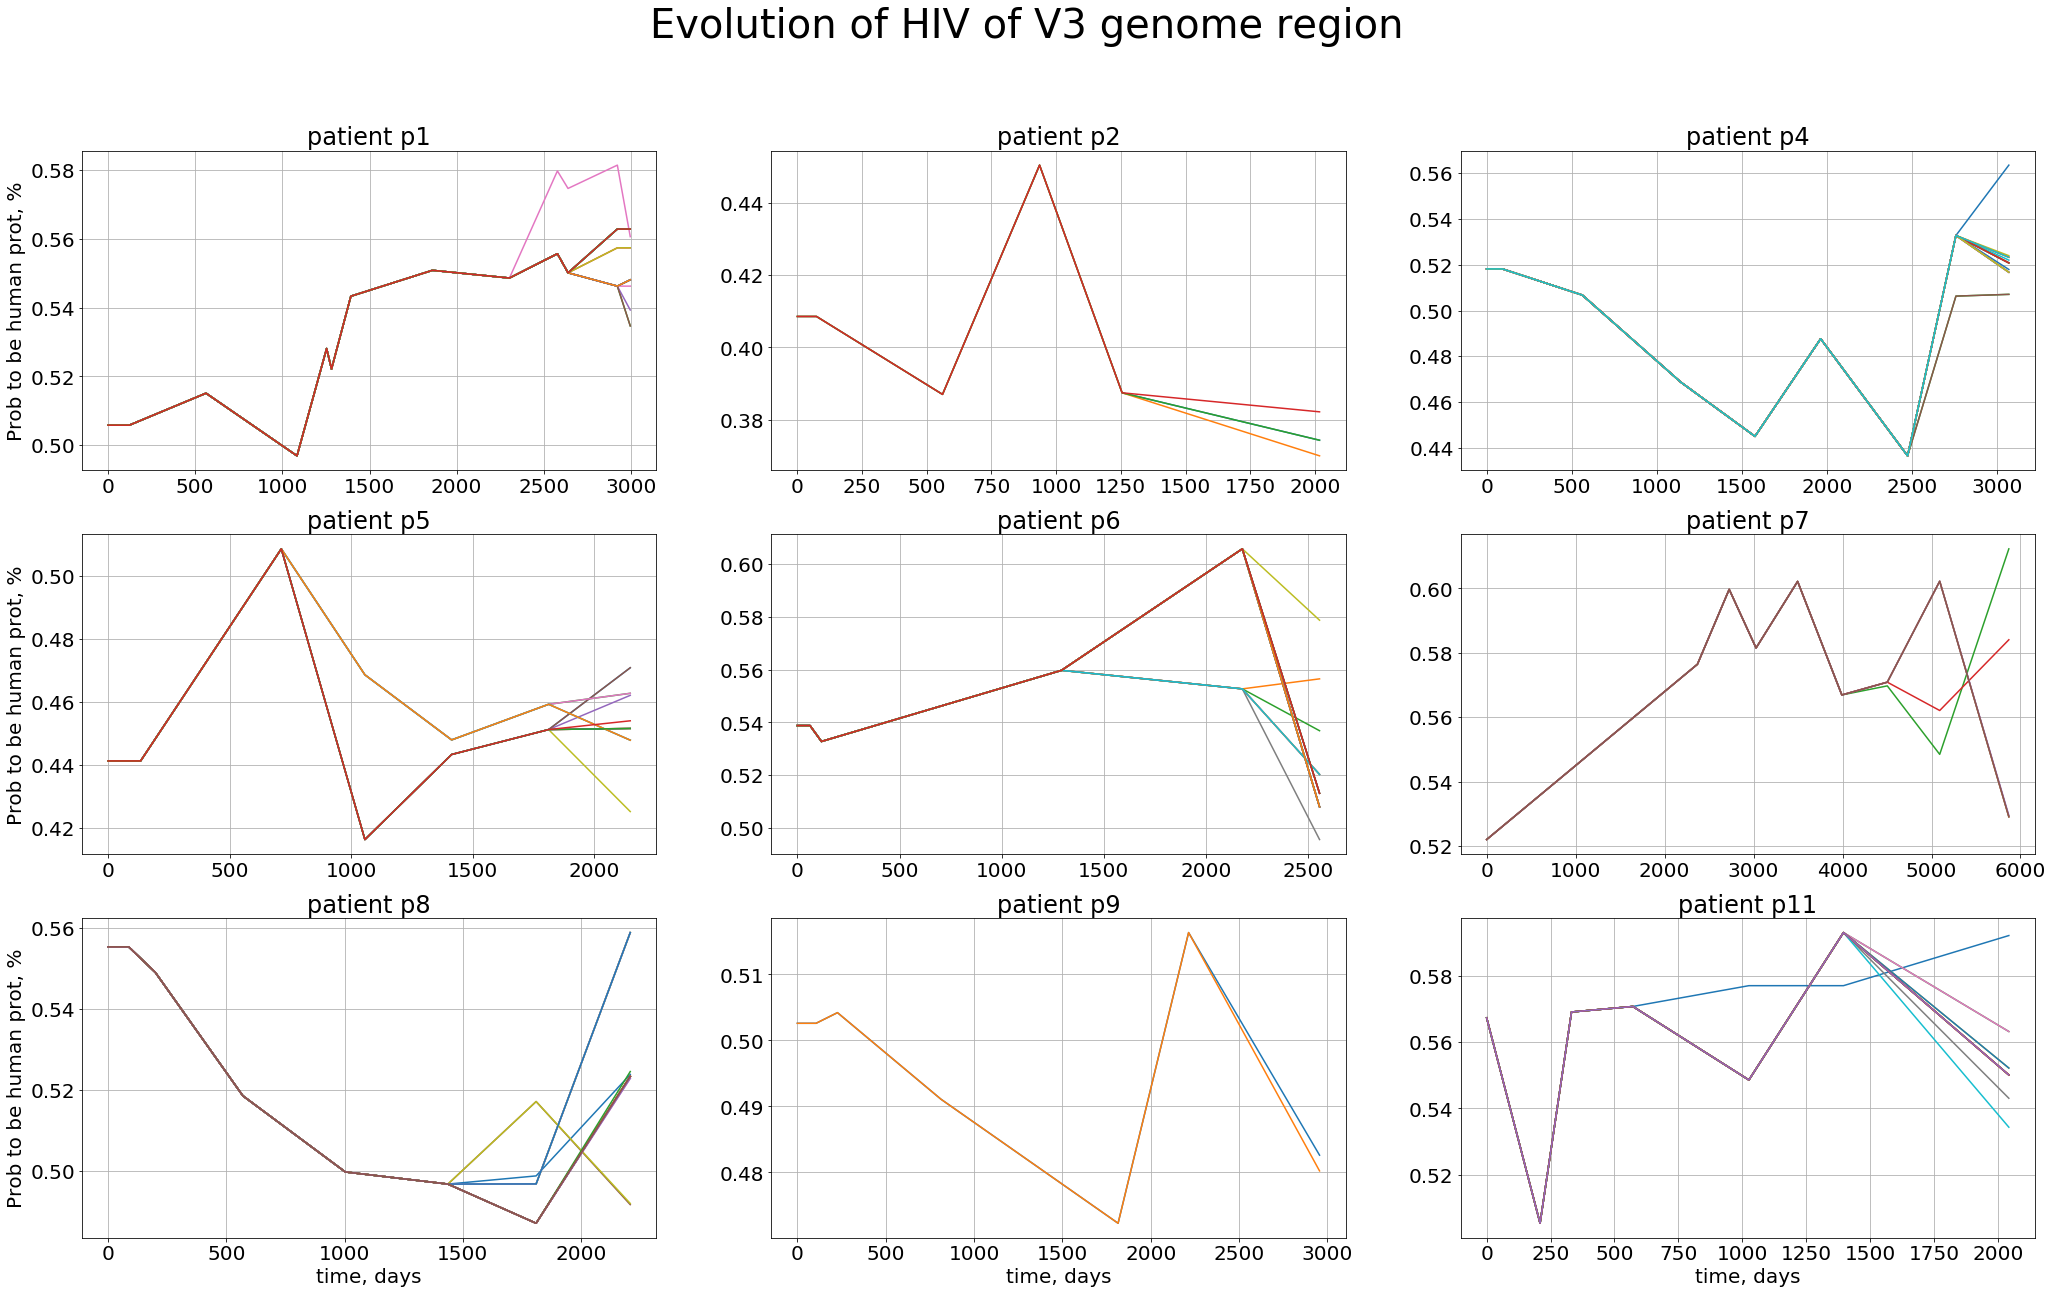

In [12]:
# Plotting

fig, axs = plt.subplots(3, 3, figsize = (35, 20), sharex = 'none', sharey = 'none')
#fig.figsize = (20, 16)
i = 0
for x in range(3):
    for y in range(3):
        for Y in pat_Y[i]:
            axs[x, y].plot(pat_X[i], Y)
            axs[x, y].set_title('patient {}'.format(patients_used[i]))
        axs[x, y].grid(alpha=1)
        i += 1

# Sadly it should be here because of my newbie skills in pyplot
axs[0, 0].set(ylabel='Prob to be human prot, %')
axs[1, 0].set(ylabel='Prob to be human prot, %')
axs[2, 0].set(ylabel='Prob to be human prot, %')

axs[2, 0].set(xlabel='time, days')
axs[2, 1].set(xlabel='time, days')
axs[2, 2].set(xlabel='time, days')

fig.suptitle('Evolution of HIV of V3 genome region', fontsize = 40)
#plt.savefig('graphs.png', quality=100, bbox_inches='tight')
plt.savefig('results/frequency_2_mer_plot/2_mer_plot.png')